<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/master/Class_04_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 4: Training for Tabular Data**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Integrative Biology](https://sciences.utsa.edu/integrative-biology/), [UTSA](https://www.utsa.edu/)

### Module 4 Material

* Part 4.1: Encoding a Feature Vector for Keras Deep Learning
* Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC
* Part 4.3: Keras Regression for Deep Neural Networks with RMSE
* **Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training**

### Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


### Lesson Setup

Run the next code cell to load necessary packages

In [2]:
# You MUST run this code cell first

%matplotlib inline
import keras
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import shutil
path = '/'
memory = shutil.disk_usage(path)
dirpath = os.getcwd()
print("Your current working directory is : " + dirpath)
print("Disk", memory)

Your current working directory is : C:\Users\David\BIO1173\Class_04_4
Disk usage(total=4000108531712, used=996802842624, free=3003305689088)


# Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training

In 1986, David Rumelhart, Geoffrey Hinton and Ronald Williams published an article in [Nature](https://corgi.genomelab.utsa.edu/BIO1173/images/Nature.pdf) with the title _Learning representations by back-propagating errors_. Since then, **_backpropagation_** has become one of the most popular methods for training neural networks. Programmers frequently train deep neural networks with backpropagation because it scales really well when run on graphical processing units (GPUs). To understand this algorithm for neural networks, we must examine how to train it as well as how it processes a pattern.

More recently, researchers have extended classic backpropagation and modified it giving rise to many different training algorithms. In this lesson we will look at a few of the most important training paradigms, beginning with classic backpropagation and ending with stochastic gradient descent (SGD).

## Backpropagation

[**_Backpropagation_**](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf) is the primary means of determining a neural network's weights during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight ($\theta$, theta) in the neural network. This value is subtracted from every weight by the following equation: 

$$ \theta_t = \theta_{t-1} - v_t $$

We repeat this process for every iteration ($t$). The training algorithm determines how we calculate the weight change. Classic backpropagation calculates a gradient ($\nabla$, nabla) for every weight in the neural network for the neural network's error function ($J$). We scale the gradient by a learning rate ($\eta$, eta).

$$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) $$

The **_learning rate_** is an important concept for backpropagation training. Setting the learning rate can be complex:

* Too low a learning rate will usually converge to a reasonable solution; however, the process will be prolonged.
* Too high of a learning rate will either fail outright or converge to a higher error than a better learning rate.

Common values for learning rate are: 0.1, 0.01, 0.001, etc.

Backpropagation is a gradient descent type, and many texts will use these two terms interchangeably. Gradient descent refers to calculating a gradient on each weight in the neural network for each training element. Gradient descent is an optimization algorithm used in training neural networks to minimize the loss function by iteratively updating the parameters (weights and biases) of the network. 

The **_gradient_** of the loss function with respect to the parameters is computed, indicating the direction in which the parameters should be adjusted to reduce the loss. The parameters are then updated in the opposite direction of the gradient, taking into account a learning rate that controls the size of the step. This process is repeated iteratively until convergence is reached, leading to the optimal set of parameters that minimize the loss function. If the neural network did output exactly what was expected, the gradient for each weight would be 0, indicating that no change to the weight is necessary.

The gradient is the **_derivative_** of the error function at the weight's current value. The gradient represents the derivative of the error function with respect to the weights of the neural network at their current values. It indicates the rate of change of the error with respect to each weight parameter, showing the direction in which the weights should be adjusted to minimize the error function. By computing the gradient, we can determine how each weight contributes to the overall error and update the weights in the direction that reduces the error, ultimately improving the performance of the neural network during training.
The error function measures the distance of the neural network's output from the expected output. We can use gradient descent, a process in which each weight's gradient value can reach even lower values of the error function. 
  
The gradient is the partial derivative of each **_weight_** in the neural network concerning the error function. Each weight has a gradient that is the slope of the error function. The term _weight_ refers to the strength of the connection between two neurons. Calculating the gradient of the error function allows the training method to determine whether it should increase or decrease the weight (connection strength). In turn, this determination will decrease the error of the neural network. The **_error_** is the difference between the expected output and actual output of the neural network. Many different training methods called propagation-training algorithms utilize gradients. In all of them, the sign of the gradient tells the neural network the following information:

* Zero gradient - The weight does not contribute to the neural network's error.
* Negative gradient - The algorithm should _increase_ the weight to lower error.
* Positive gradient - The algorithm should _decrease_ the weight to lower error.


Because many algorithms depend on gradient calculation, we will begin with an analysis of this process. 

### Gradient Calculations

First of all, let's examine the gradient. Essentially, training is a search for the set of weights that will cause the neural network to have the lowest error for a training set. If we had infinite computation resources, we would try every possible combination of weights to determine the one that provided the lowest error during the training. 

Because we do not have unlimited computing resources, we have to use some shortcuts to prevent the need to examine every possible weight combination. These training methods utilize clever techniques to avoid performing a brute-force search of all weight values. This type of exhaustive search would be impossible because even small networks have an infinite number of weight combinations.

In training neural networks, gradient calculations are made using the backpropagation algorithm. The process involves computing the gradient of the loss function with respect to the weights of the network by applying the chain rule of calculus.

* **Forward Pass:** The input data is passed through the network, and the output is computed. The loss function is then evaluated using the predicted output and the actual labels.
* **Backward Pass (Backpropagation):** The gradient of the loss function with respect to the output of the network is calculated first, and then the gradients are recursively propagated backward through the network layers. This process involves computing the gradient of the loss with respect to the activations of each layer, and then using these gradients to compute the gradients with respect to the weights of the network.
* **Gradient Descent:** Once the gradients with respect to the weights are calculated, the weights are updated using an optimization algorithm like gradient descent. The weights are adjusted in the direction opposite to the gradient, with the magnitude of the update determined by the learning rate.

By iteratively updating the weights based on the calculated gradients, the neural network learns to minimize the loss function and improve its performance on the training data.

Consider the chart below that shows the error of a neural network for each possible weight. This chart is a graph showing the error for a single weight:

![Derivative](https://biologicslab.co/BIO1173/images/class_2_deriv2.png "Derivative")

Looking at this chart, you can easily see that the **_optimal weight_** is where the black line has the lowest y-value (Optimal wt). The problem is that we see only the error for the current value of the weight; we do not see the entire graph because that process would require an exhaustive search. 

We can, however, determine the slope of the error curve at a particular weight. In the above chart, we can see the slope of the error curve at 1.5. The straight blue line, that barely touches the error curve at 1.5, gives the slope. In this case, the slope, or gradient, is -0.5622. The negative slope indicates that an _increase_ in the weight will _lower_ the error.

The gradient is the instantaneous slope of the error function at the specified weight. The derivative of the error curve at that point gives the gradient. This line tells us the steepness of the error function at the given weight.  

Derivatives are one of the most fundamental concepts in calculus. For this course, you need to understand that a derivative provides the slope of a function at a specific point. A training technique and this slope can give you the information to adjust the weight for a lower error. Using our working definition of the gradient, we will show how to calculate it.

## Momentum Backpropagation

In physics, **_momentum_** is a vector quantity that represents the motion of an object and is calculated as the product of its mass and velocity. It describes the quantity of motion an object possesses and the difficulty in stopping it.

In the context of optimization algorithms such as gradient descent, momentum is a technique that aims to accelerate convergence by adding a fraction of the previous update to the current update. This helps to smooth out variations in the gradient and speed up convergence, especially in the presence of noisy or sparse gradients.

Momentum adds another term to the calculation of $v_t$:

$$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) + \lambda v_{t-1} $$

Like the learning rate, momentum adds another training parameter that scales the effect of momentum. Momentum backpropagation has two training parameters: learning rate ($\eta$, eta) and momentum ($\lambda$, lambda). Momentum adds the scaled value of the previous weight change amount ($v_{t-1}$) to the current weight change amount($v_t$).

This technique has the effect of adding additional force behind the direction a weight is moving. In other words, momentum **_keeps_** pushing for a change in the weight, even when the slope might be zero. In certain situations, unless the weight is changed, the model might get "trapped" within local minimum that is far from the true minimum. The figure below shows how momentum might allow the weight to escape local minima.

![Momentum](https://biologicslab.co/BIO1173/images/class_5_momentum.png "Momentum ")

A typical value for momentum is 0.9.

Using momentum in training a neural network can have some drawbacks, including:

* **Overshooting:** High momentum values can lead to overshooting, where the optimization algorithm oscillates or overshoots the minimum point, causing instability and slower convergence.
* **Local Minima:** Momentum can sometimes make it harder for the optimization algorithm to escape local minima, as the accumulated momentum may prevent the algorithm from exploring other regions of the parameter space.
* **Sensitivity to Hyperparameters:** Choosing the right momentum value can be crucial, as selecting a suboptimal value can negatively impact the training process and result in poor convergence.
* **Increased Complexity:** Incorporating momentum adds an additional hyperparameter to tune, increasing the complexity of the training process and potentially requiring more computational resources.
* **Difficulty in Interpretation:** Momentum may introduce additional complexity in interpreting and understanding the training behavior of the neural network, making it harder to diagnose issues or optimize the training process effectively.

## Batch and Online Backpropagation

While it is possible to calculate gradients for element in a training set, gradients can also be summed together into **_batches_**, and the weights updated once per batch.

In training neural networks, batches refer to dividing the training data into smaller subsets to update the model's parameters more frequently during optimization. This process is known as _mini-batch gradient descent_, where the gradients are computed for each batch and the model parameters are updated accordingly. 

Batches are useful in the following scenarios:
* **Efficiency:** Training neural networks on large datasets can be computationally intensive. Using batches allows for more frequent parameter updates, making the optimization process more efficient compared to updating the parameters after processing the entire dataset (batch gradient descent).
* **Memory Constraints:** Processing the entire dataset at once may exceed the memory capacity of the system. Batching the data helps in managing memory constraints by loading and processing smaller subsets at a time.
* **Generalization:** Batching introduces noise into the gradient estimates, which can help prevent the optimization process from getting stuck in local minima and improve the generalization of the model.
* **Parallelism:** Training on batches enables parallelization of computations, allowing for faster training on hardware with multiple processors or GPUs.
* **Stability:** Using batches can improve the stability of the training process by reducing the variance of parameter updates, leading to smoother convergence and improved optimization performance.

When using batches, additional parameters need to be specified:

* **Online Training** - Update the weights based on gradients calculated from a single training set element.
* **Batch Training** - Update the weights based on the sum of the gradients over all training set elements.
* **Batch Size** - Update the weights based on the sum of some batch size of training set elements.
* **Mini-Batch Training** - The same as batch size, but with minimal batch size.  Mini-batches are very popular, often in the 32-64 element range.

Because the batch size is smaller than the full training set size, it may take several batches to make it completely through the training set.  

* **Step/Iteration** - The number of processed batches.
* **Epoch** - The number of times the algorithm processed the complete training set.

Batch processing will be very important when we start processing images with convolutional neural networks later in this course. 


## Stochastic Gradient Descent

**_Stochastic gradient descent (SGD)_** is currently one of the most popular neural network training algorithms.  It works very similarly to Batch/Mini-Batch training, except that the batches are made up of a random set of training elements.

Stochastic gradient descent is commonly used in training neural networks when dealing with large datasets as it offers faster convergence compared to traditional batch gradient descent. Additionally, stochastic gradient descent is useful when working with noisy data or when the loss function is flat, as it introduces randomness that can help escape local minima. However, it may result in higher variance in the learning process due to its stochastic nature.

This technique leads to a very irregular convergence in error during training, as shown in the figure below.

![SGD  Error](https://biologicslab.co/BIO1173/images/class_5_sgd_error.png "SGD Error")


[Image from Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

Because the neural network is trained on a random sample of the complete training set each time, the error does not make a smooth transition downward.  However, the error usually does go down.

Advantages to SGD include:

* **Computationally efficient.**  Each training step can be relatively fast, even with a huge training set.
* **Decreases overfitting** by focusing on only a portion of the training set each step.


## Other Techniques

One problem with simple backpropagation training algorithms is that they are susceptible to learning rate and momentum. This technique is difficult because:

* **Learning rate** must be adjusted to a small enough level to train an accurate neural network.
* **Momentum** must be large enough to overcome local minima yet small enough not to destabilize the training.
* **A single learning rate/momentum** is often not good enough for the entire training process. It is often helpful to automatically decrease the learning rate as the training progresses.
* **All weights** share a single learning rate/momentum.

Other training techniques:

* **Resilient Propagation** - Use only the magnitude of the gradient and allow each neuron to learn at its rate. There is no need for learning rate/momentum; however, it only works in full batch mode.
* **Nesterov accelerated gradient** - Helps mitigate the risk of choosing a bad mini-batch.
* **Adagrad** - Allows an automatically decaying per-weight learning rate and momentum concept.
* **Adadelta** - Extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
* **Non-Gradient Methods** - Non-gradient methods can *sometimes* be useful, though rarely outperform gradient-based backpropagation methods.  These include: [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing), [genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm), [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization), [Nelder Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), and [many more](https://en.wikipedia.org/wiki/Category:Optimization_algorithms_and_methods).

## ADAM Update

**_ADAM_** is the first training algorithm you should try.  It is very effective.  Kingma and Ba (2014) introduced the Adam update rule that derives its name from the adaptive moment estimates. [[Cite:kingma2014adam]](https://arxiv.org/abs/1412.6980)  Adam estimates the first (mean) and second (variance) moments to determine the weight corrections.  Adam begins with an exponentially decaying average of past gradients (m):

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $$

This average accomplishes a similar goal as classic momentum update; however, its value is calculated automatically based on the current gradient ($g_t$).  The update rule then calculates the second moment ($v_t$):

$$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $$

The values $m_t$ and $v_t$ are estimates of the gradients' first moment (the mean) and the second moment (the uncentered variance).  However, they will be strongly biased towards zero in the initial training cycles.  The first moment’s bias is corrected as follows.

$$ \hat{m}_t = \frac{m_t}{1-\beta^t_1} $$

Similarly, the second moment is also corrected:

$$ \hat{v}_t = \frac{v_t}{1-\beta_2^t} $$

These bias-corrected first and second moment estimates are applied to the ultimate Adam update rule, as follows:

$$ \theta_t = \theta_{t-1} - \frac{\alpha \cdot \hat{m}_t}{\sqrt{\hat{v}_t}+\eta} \hat{m}_t $$

Adam is very tolerant to initial learning rate ($\alpha$) and other training parameters. Kingma and Ba (2014)  propose default values of 0.9 for $\beta_1$, 0.999 for $\beta_2$, and 10-8 for $\eta$.

The choice of optimizer for Keras regression neural networks can vary depending on the specific dataset, network architecture, and training requirements. However, some commonly used optimizers that have been effective for regression tasks in Keras include:

* **Adam:** Adam (Adaptive Moment Estimation) is a popular optimizer that combines the benefits of adaptive learning rates and momentum. It is known for its fast convergence and good performance across a wide range of tasks.
* **RMSprop:** RMSprop (Root Mean Square Propagation) is an adaptive learning rate optimization algorithm that divides the learning rate by the square root of the exponentially weighted moving average of squared gradients. RMSprop is suitable for dealing with non-stationary objectives in regression tasks.
* **SGD with Momentum:** Stochastic Gradient Descent (SGD) with momentum accelerates convergence by adding a fraction of the update from the previous time step. This helps to smooth out variations in the gradient and improve convergence speed.
* **Adagrad:** Adagrad is an adaptive learning rate optimization algorithm that scales the learning rate based on the frequency of feature occurrences. It performs well in regression tasks with sparse data or varying feature importance.
* **Nadam:** Nadam is an extension of Adam that incorporates the benefits of Nesterov Accelerated Gradient (NAG) into the Adam optimizer. It combines ideas from Adam and NAG to provide faster convergence and better generalization for regression tasks.


## Methods Compared

The following image shows an animation of how each of these algorithms train. It can be accessed from here: [https://bit.ly/3kykkbn](https://bit.ly/3kykkbn).

![Training Techniques](https://biologicslab.co/BIO1173/images/contours_evaluation_optimizers.gif "Training Techniques")

Image credits: [Alec Radford](https://scholar.google.com/citations?user=dOad5HoAAAAJ&hl=en)

## Specifying the Update Rule in Keras

Keras offers various update rules that can be used during the optimization process. Some of the update rules allowed by Keras include:

* **Adam (Adaptive Moment Estimation):** A popular optimization algorithm that combines the benefits of momentum and AdaGrad while alleviating their limitations.
* **SGD (Stochastic Gradient Descent):** A basic optimization algorithm that updates the model parameters based on the average of the gradients computed from a mini-batch of data.
* **RMSprop (Root Mean Square Propagation):** An adaptive learning rate method that divides the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight.
* **Adagrad (Adaptive Gradient Algorithm):** An adaptive learning rate method that adapts the learning rate for each parameter based on the historical gradients for that parameter.
* **Adadelta:** An extension of Adagrad that seeks to alleviate Adagrad's aggressive, monotonically decreasing learning rate by using a running average of parameter updates.
* **Adamax:** A variant of the Adam optimizer that replaces the L2 norm with the L infinity norm while updating the parameters.

These update rules provide flexibility and options for optimizing neural network models with different characteristics and training requirements. Different update rules may perform better for specific problems or in different network architectures, and Keras allows users to experiment with and choose the most suitable update rule for their training tasks.

# Changing optimizer and learning rates

In the last section of this lesson, we look at the effect of changing the optimizer and the learning rate on neural network training. 

For this section, we will use the Obesity Data Set that we have seen in previous lessons.

### **Obesity Data Set**

[Obesity Data Set](https://archive.ics.uci.edu/ml/datasets/)


![_____](https://biologicslab.co/BIO1173/images/obesity.jpg)

**Description:**

The Obesity Data Set includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of `Insufficient Weight`, `Normal Weight`, `Overweight Level I`, `Overweight Level II`, `Obesity Type I`, `Obesity Type II` and `Obesity Type III`. 

**Key Features:**

* **Gender-** Female/Male
* **Age-** Numeric value
* **Height-** Numeric value in meters
* **Weight-** Numeric value in kilograms
* **family_history_with_overweight-** Has a family member suffered or suffers from overweight - Yes/No
* **FAVC-** Do you eat high caloric food frequently - Yes/No
* **FCVC-** Do you usually eat vegetables in your meals - Never/Sometimes/Always
* **NCP-** How many main meals do you have daily - Between 1 y 2/Three/More than three
* **CAEC-** Do you eat any food between meals? - No/Sometimes/Frequently/Always
* **SMOKE-** Do you smoke? - Yes/No
* **CH2O-** How much water do you drink daily? - Less than a liter/Between 1 and 2 L/More than 2 L
* **SCC-** Do you monitor the calories you eat daily - Yes/No
* **FAF-** How often do you have physical activity? - I do not have/1 or 2 days/2 or 4 days/4 or 5 days
* **TUE-** How much time do you use technological devices such as cell phone, videogames, television, computer and others - 0–2 hours/3–5 hours/More than 5 hours
* **CALC-** How often do you drink alcohol? - I do not drink/Sometimes/Frequently/Always
* **MTRANS-** Which transportation do you usually use? Automobile/Motorbike/Bike/Public Transportation/Walking
* **NObeyesdad-** Obesity levels: 'Insufficient_Weight', 'Obesity_Type_III', 'Normal_Weight', 'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_I', 'Overweight_Level_II'

For our regression neural network, the response variable (Y) will be the column `NObeyesdad`. Since this column contains 7 categorical variables, we are going to map these variables to strings as follows:

* 'Insufficient_Weight' = 0
* 'Normal_Weight'       = 1
* 'Overweight_Level_I'  = 2
* 'Overweight_Level_II' = 3
* 'Obesity_Type_I'      = 4
* 'Obesity_Type_II'     = 5
* 'Obesity_Type_III'    = 6

In other words, instead of having a response variable that is a continuous numerical value (e.g. 5.321 to 8.786), the response variable for the Obesity Data Set will be a discrete integer, between 0 and 6. As you will see later, this will produce a rather unique regression chart below. 

### Define Function to Plot Regression Chart

The code in the cell below will be used later to generate a Lift Chart for each regression model.

In [3]:
# Regression chart.
def chart_regression(pred, y, lr, sort=True):
    stitle="Learning Rate = " + str(lr)
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.title(stitle)
    plt.legend()
    plt.show()

### Read in the data

The code in the cell below reads in the data from the course HTTPS server and creates a DataFrame called `df`. Assigning `df` as the name of DataFrame is often seen in Python code examples.  

Once the data is read and the DataFrame created, the data is shuffled. 

In [4]:
# Example

# Read data and create DataFrame-------------------------------------
df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?'])

# Set the random seed to 42
np.random.seed(42) 

# Use random.permutation function for shuffling & reindexing
df = df.reindex(np.random.permutation(df.index))

# Set max rows and max columns
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 6)  # Zero means all columns

# Display DataFrame-------------------------------------------------
display(df)

,Gender,Age,Height,...,CALC,MTRANS,NObeyesdad
544,Female,20.406871,1.755978,...,no,Public_Transportation,Insufficient_Weight
1987,Female,26.000000,1.624950,...,Sometimes,Public_Transportation,Obesity_Type_III
420,Male,18.000000,1.850000,...,Sometimes,Automobile,Insufficient_Weight
...,...,...,...,...,...,...,...
1130,Female,22.989846,1.650000,...,no,Public_Transportation,Overweight_Level_II
1294,Female,23.000000,1.628168,...,no,Public_Transportation,Obesity_Type_I
860,Male,20.000000,1.817480,...,Sometimes,Public_Transportation,Overweight_Level_I


If your code is correct your should see something similar to the following table:

![__](https://biologicslab.co/BIO1173/images/class_04_4_Ob.png)

### Preprocess the data

The code in the cell below converts categorical variables into numerical values either by (1) mapping string values to integers or (2) using one-hot encoding to create dummy columns. The mapping of the response column `NObeyesdad` to integers `0`-`6` should be noted. Numeric values in the columns `Height` and `Weight` have been standardized to their Z-scores. 

The numeric values in all of the columns, with the exception of the response column `NObeyesdad`, are used to generate the X feature vector. 

As a final step, the data is split into training and test sets and the X-values for the first 3 subjects in the test set (`xtest`) are printed out. 

In [5]:
# Preprocess data

# Map Gender
mapping = {'Male': 1, 'Female': 0}
df['Gender'] = df['Gender'].map(mapping)

# Map family_history_with_overweight
mapping = {'yes': 1, 'no': 0}
df['family_history_with_overweight'] = df['family_history_with_overweight'].map(mapping)

# Map FAVC
mapping = {'yes': 1, 'no': 0}
df['FAVC'] = df['FAVC'].map(mapping)

# Map SMOKE
mapping = {'yes': 1, 'no': 0}
df['SMOKE'] = df['SMOKE'].map(mapping)

# Map SCC
mapping = {'yes': 1, 'no': 0}
df['SCC'] = df['SCC'].map(mapping)

# Map NObeyesdad
mapping2 = {'Insufficient_Weight': 0,
            'Normal_Weight': 1,
            'Overweight_Level_I': 2,
            'Overweight_Level_II': 3,
            'Obesity_Type_I': 4,
            'Obesity_Type_II': 5,
            'Obesity_Type_III': 6}

df['NObeyesdad'] = df['NObeyesdad'].map(mapping2)

# Generate dummies for CAEC
df = pd.concat([df,pd.get_dummies(df['CAEC'],prefix="CAEC")],axis=1)
df.drop('CAEC', axis=1, inplace=True)

# Generate dummies for CALC
df = pd.concat([df,pd.get_dummies(df['CALC'],prefix="CALC")],axis=1)
df.drop('CALC', axis=1, inplace=True)

# Generate dummies for MTRANS
df = pd.concat([df,pd.get_dummies(df['MTRANS'],prefix="MTRANS")],axis=1)
df.drop('MTRANS', axis=1, inplace=True)

# Standardize ranges
df['Height'] = zscore(df['Height'])
df['Weight'] = zscore(df['Weight'])

# Generate X feature vector
x_columns = df.columns.drop('NObeyesdad')
x = df[x_columns].values
x = np.asarray(x).astype('float32')

# Generate Y feature vector
y = df['NObeyesdad'].values
y = np.asarray(y).astype('float32')

# Split data
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=408)

# Print
print (y_test)

[1. 5. 6. 2. 2. 3. 6. 5. 0. 3. 6. 6. 3. 4. 6. 0. 5. 4. 2. 3. 6. 3. 2. 4.
 3. 1. 0. 0. 2. 6. 3. 5. 1. 5. 1. 5. 6. 6. 6. 6. 1. 0. 3. 5. 3. 1. 5. 4.
 6. 4. 5. 1. 1. 1. 2. 3. 4. 5. 1. 4. 3. 2. 3. 5. 0. 0. 4. 5. 0. 3. 1. 1.
 4. 6. 2. 1. 0. 2. 3. 1. 3. 0. 4. 0. 3. 5. 1. 4. 4. 1. 4. 3. 6. 3. 4. 5.
 1. 4. 6. 1. 3. 5. 3. 0. 3. 3. 6. 6. 4. 6. 3. 6. 6. 0. 5. 6. 5. 3. 4. 2.
 3. 6. 1. 5. 3. 4. 5. 4. 1. 0. 1. 4. 5. 2. 2. 5. 6. 6. 3. 2. 2. 1. 5. 3.
 0. 4. 3. 2. 0. 4. 3. 3. 4. 6. 6. 0. 6. 2. 0. 0. 3. 4. 4. 1. 3. 3. 4. 5.
 0. 6. 4. 0. 1. 2. 1. 0. 6. 0. 2. 1. 6. 1. 3. 0. 6. 5. 0. 2. 4. 6. 3. 3.
 2. 3. 6. 4. 1. 5. 6. 1. 5. 5. 1. 5. 4. 5. 6. 3. 3. 5. 6. 6. 0. 2. 5. 3.
 4. 6. 6. 4. 4. 3. 4. 5. 1. 4. 6. 5. 4. 3. 4. 3. 4. 4. 5. 2. 0. 2. 2. 6.
 4. 0. 0. 1. 2. 4. 4. 1. 6. 6. 5. 2. 6. 3. 4. 1. 5. 0. 4. 6. 5. 4. 2. 5.
 4. 6. 6. 0. 4. 6. 1. 3. 4. 6. 5. 0. 5. 5. 1. 6. 6. 4. 5. 1. 6. 4. 2. 0.
 1. 5. 6. 6. 1. 3. 3. 6. 4. 1. 3. 0. 5. 3. 4. 4. 3. 3. 1. 2. 5. 3. 3. 6.
 0. 2. 4. 4. 3. 6. 3. 5. 1. 4. 0. 2. 4. 5. 6. 3. 2.

If your code is correct you should see something similar to the following output:

~~~text
[1. 5. 6. 2. 2. 3. 6. 5. 0. 3. 6. 6. 3. 4. 6. 0. 5. 4. 2. 3. 6. 3. 2. 4.
 3. 1. 0. 0. 2. 6. 3. 5. 1. 5. 1. 5. 6. 6. 6. 6. 1. 0. 3. 5. 3. 1. 5. 4.
 6. 4. 5. 1. 1. 1. 2. 3. 4. 5. 1. 4. 3. 2. 3. 5. 0. 0. 4. 5. 0. 3. 1. 1.
 4. 6. 2. 1. 0. 2. 3. 1. 3. 0. 4. 0. 3. 5. 1. 4. 4. 1. 4. 3. 6. 3. 4. 5.
 1. 4. 6. 1. 3. 5. 3. 0. 3. 3. 6. 6. 4. 6. 3. 6. 6. 0. 5. 6. 5. 3. 4. 2.
 3. 6. 1. 5. 3. 4. 5. 4. 1. 0. 1. 4. 5. 2. 2. 5. 6. 6. 3. 2. 2. 1. 5. 3.
 0. 4. 3. 2. 0. 4. 3. 3. 4. 6. 6. 0. 6. 2. 0. 0. 3. 4. 4. 1. 3. 3. 4. 5.
 0. 6. 4. 0. 1. 2. 1. 0. 6. 0. 2. 1. 6. 1. 3. 0. 6. 5. 0. 2. 4. 6. 3. 3.
 2. 3. 6. 4. 1. 5. 6. 1. 5. 5. 1. 5. 4. 5. 6. 3. 3. 5. 6. 6. 0. 2. 5. 3.
 4. 6. 6. 4. 4. 3. 4. 5. 1. 4. 6. 5. 4. 3. 4. 3. 4. 4. 5. 2. 0. 2. 2. 6.
 4. 0. 0. 1. 2. 4. 4. 1. 6. 6. 5. 2. 6. 3. 4. 1. 5. 0. 4. 6. 5. 4. 2. 5.
 4. 6. 6. 0. 4. 6. 1. 3. 4. 6. 5. 0. 5. 5. 1. 6. 6. 4. 5. 1. 6. 4. 2. 0.
 1. 5. 6. 6. 1. 3. 3. 6. 4. 1. 3. 0. 5. 3. 4. 4. 3. 3. 1. 2. 5. 3. 3. 6.
 0. 2. 4. 4. 3. 6. 3. 5. 1. 4. 0. 2. 4. 5. 6. 3. 2. 2. 2. 2. 2. 1. 5. 2.
 5. 4. 0. 5. 3. 5. 5. 2. 0. 5. 4. 4. 4. 3. 1. 6. 5. 4. 0. 3. 6. 0. 4. 3.
 2. 2. 4. 4. 1. 5. 2. 0. 2. 4. 4. 4. 1. 0. 6. 1. 0. 3. 0. 3. 6. 1. 5. 4.
 2. 6. 3. 1. 2. 3. 3. 6. 1. 1. 2. 1. 5. 6. 1. 1. 2. 5. 4. 6. 4. 1. 1. 5.
 2. 1. 6. 4. 6. 5. 2. 2. 0. 0. 1. 6. 4. 0. 2. 1. 4. 0. 4. 6. 2. 4. 2. 0.
 4. 4. 4. 1. 6. 4. 1. 6. 5. 2. 3. 2. 5. 1. 1. 0. 3. 6. 4. 1. 6. 4. 2. 6.
 0. 4. 6. 4. 0. 2. 0. 3. 4. 1. 2. 5. 1. 2. 5. 1. 5. 1. 3. 5. 0. 4. 4. 5.
 2. 0. 4. 6. 0. 2. 0. 3. 0. 4. 2. 0. 1. 2. 0. 2. 4. 4. 4. 5. 6. 2. 0. 1.
 2. 0. 2. 1. 2. 2. 1. 3. 1. 1. 4. 3. 2. 6. 6. 5. 2. 3. 3. 5. 4. 3. 4. 4.]
~~~

The above array represent **all** of the actual Y values in the test data set. As you can see, the Y-values are discrete integers ranging from `0` for `Insufficient_Weight` to `6` for 'Obesity_Type_III'.

### Example 1: Optimizer = Adam, Learning rate = 0.01

The code in the cell below constructs a regression neural network with the `Adam` optimizer and a learning rate = 0.01. The learning rate is set with the variable `lrate` at the start of the code cell. The `Adam` optimizer is set in the compiler with the following line of code:
~~~text
optimizer=keras.optimizers.Adam(learning_rate=lrate)`
~~~

Restoring model weights from the end of the best epoch: 68.
Epoch 78: early stopping
17/17 [==============================] - 0s 1ms/step


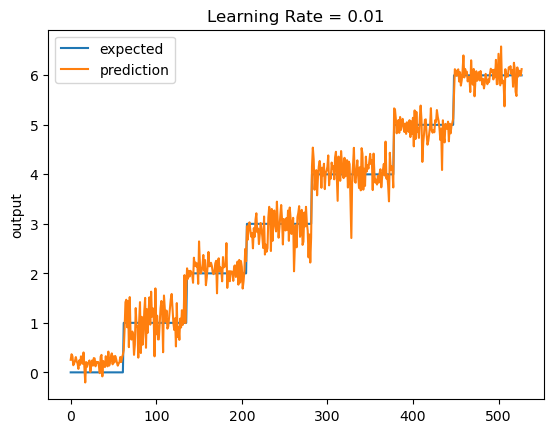

In [6]:
# Example 1: Optimizer = adam, Learning rate = 0.01

# Set learning rate
lrate = 0.01

# Construct model
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

# Compile with DIFFERENT optimizers
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(learning_rate=lrate)
             )

# Create monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)
# Fit model
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=0,epochs=1000)

# Plot the chart
pred = model.predict(x_test)
chart_regression(pred.flatten(),y_test, lrate)

To economize on space, the model is being trained with `verbose=0`. In other words, no output will be visible until training has finished. 
**So please be patient**.

If your code is correct you should see something similar the following Lift Chart.

![___](https://biologicslab.co/BIO1173/images/class_04_Exe1.png)

The solid blue line are the actual Y-values of **all** subjects in the test set (_n_=530). The values have been sorted from lowest to highest and then plotted from left to right. There are exactly `7` "steps" corresponding to the `7` categorical levels in the response variable `NObeyesdad`. For example, the first "step" at Y=0, are the approximately 75 subjects in the test set who were classified as being 'Insufficient_Weight'. The last, and highest step, at Y=6, correspond to the 75 test subjects who were classified as being `Obesity_Type_III`. 

The "jaggy" orange line shows the model's corresponding predicted value for each test subject. By inspection you can see that the model predicted Y-values follow the stair-step increase in the actual Y-values, albeit in a rather noisy fashion.    

### **Exercise 1: Optimizer = Adam, Learning rate = 0.1**

In the cell below, write the code to repeat Example 1 again using the `Adam` optimizer, but this time increase the learing rate to 0.1.

Set `verbose=0` when you fit the model.

Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping
17/17 [==============================] - 0s 1ms/step


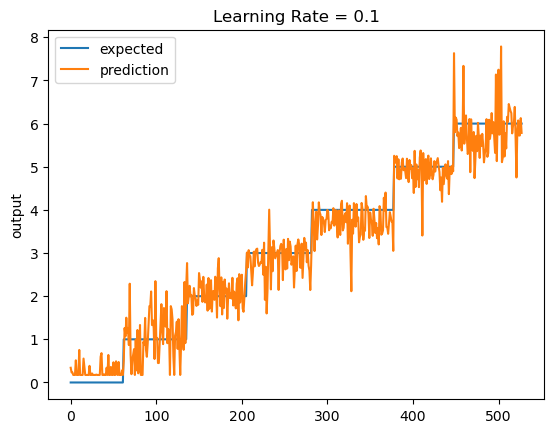

In [7]:
# Insert your code for Exercise 1 here

# Set learning rate
lrate = 0.1

# Construct model
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

# Compile with DIFFERENT optimizers
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(learning_rate=lrate)
             )

# Create monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)
# Fit model
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=0,epochs=1000)

# Plot the chart
pred = model.predict(x_test)
chart_regression(pred.flatten(),y_test, lrate)

If your code is correct you should see something similiar the following Lift Chart.

![_](https://biologicslab.co/BIO1173/images/class_04_Exe2A.png)

Increasing the Learning Rate from 0.01 to 0.1 may (or may not) prevent training. In the Lift Chart shown above, the model simply predicted 3.1519866, basically the average (mean) value between 0 and 6, for all subjects in the test set. 

When the learning rate is set too high any one of the following might occur:
* The training process may become unstable and the model may fail to converge to an optimal solution.
* The model may overshoot the minimum and start oscillating or diverging.
* The updates to the weights may be too large, causing the model to skip over the optimal solution.
* The loss function may fluctuate significantly, making it difficult to determine if the model is improving.
* The model may never reach a good solution and perform poorly on new data.

It is also possible that you could get a similar result as that shown in Example 1 with the Adam optimizer and a learning rate set to 0.1.  

### **Exercise 2: Optimizer = SGD, Learning rate = 0.001**

In the cell below, write the code to repeat Example 1 again but this time using the `SGD` optimizer (Stochastic Gradient Descent) with the learing rate set to 0.001. Just change the word `Adam` to `SGD` in the compiler and the variable `lrate`.

Be prepared to wait for the training to complete since 0.001 is a slower rate than before.

Restoring model weights from the end of the best epoch: 133.
Epoch 143: early stopping
17/17 [==============================] - 0s 1ms/step


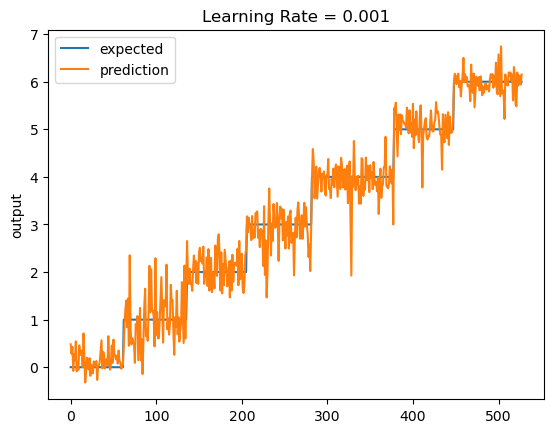

In [8]:
# Insert your code for Exercise 2 here

# Set learning rate
lrate = 0.001

# Construct model
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

# Compile with DIFFERENT optimizers
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.SGD(learning_rate=lrate)
             )

# Create monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)
# Fit model
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=0,epochs=1000)

# Plot the chart
pred = model.predict(x_test)
chart_regression(pred.flatten(),y_test, lrate)

If your code is correct you should see something similiar the following Lift Chart.

![___](https://biologicslab.co/BIO1173/images/class_04_Exe3.png)

The model's predictions using the Stocastic Descent Graient (SGD) optimizer appear more "jagged" than before with the Adam optimizer. This "jaggedness" means the predictions are more noisy, overshooting and undershooting the actual prediction.  

### **Exercise 3: Optimizer = SGD, Learning rate = 0.01**

In the cell below, write the code to repeat **Exercise 2**, again using the `SGD` optimizer (Stochastic Gradient Descent), but set the learing rate set to 0.01. 

Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
17/17 [==============================] - 0s 2ms/step


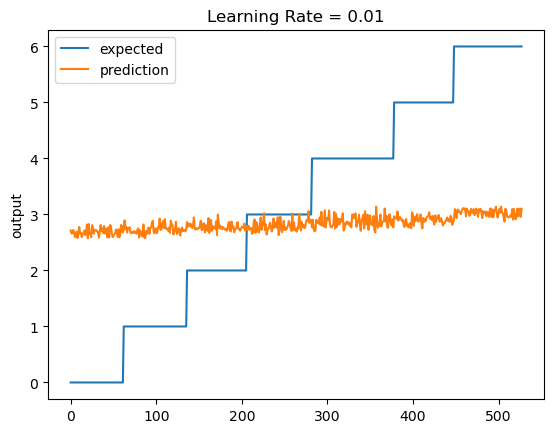

In [9]:
# Insert your code for Exercise 3 here

# Set learning rate
lrate = 0.01

# Construct model
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

# Compile with DIFFERENT optimizers
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.SGD(learning_rate=lrate)
             )

# Create monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)
# Fit model
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=0,epochs=1000)

# Plot the chart
pred = model.predict(x_test)
chart_regression(pred.flatten(),y_test, lrate)

If your code is correct you should see something similiar the following Lift Chart.

![___](https://biologicslab.co/BIO1173/images/class_04_Exe4.png)

In this example, a learning rate of 0.01 was too fast for the Stochastic Gradient Descent optimizer. Again, all of the the model's predictions were about the average value (3) of the actual Y values. 

### **Exercise 4: Optimizer = Nadam, Learning rate = 0.01**

In the cell below, write the code to repeat **Exercise 2**, again using the `Nadam` optimizer with a learning rate set to 0.01. 

As explained above, **_Nadam_** is an extension of Adam that incorporates the benefits of Nesterov Accelerated Gradient (NAG) into the Adam optimizer. It combines ideas from Adam and NAG to provide faster convergence and better generalization for regression tasks.

Restoring model weights from the end of the best epoch: 34.
Epoch 44: early stopping
17/17 [==============================] - 0s 2ms/step


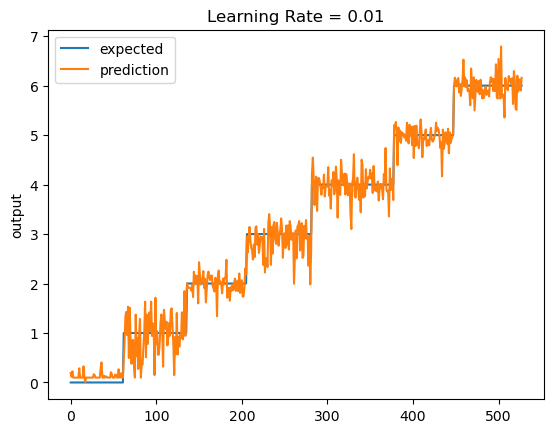

In [10]:
# Insert your code for Exercise 4 here

# Set learning rate
lrate = 0.01

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

# Compile with DIFFERENT optimizers
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Nadam(learning_rate=lrate)
              )

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=0,epochs=1000)

# Plot the chart
pred = model.predict(x_test)
chart_regression(pred.flatten(),y_test,lrate)

If your code is correct you should see something similiar the following Lift Chart.

![___](https://biologicslab.co/BIO1173/images/class_04_Exe5.png)

Using the Nadam optimizer doesn't appear to improve the model's predictions based on the "jagginess" of the orange line. If anything, the predictions are more noisy. However, it should be keep in mind that the effectiveness of any optimizer depends on the neural network model and the dataset. 

## **Lesson Turn-in**

When you have completed all of the code cells, and run them in sequential order (the last code cell should be number 10), use the **File --> Print.. --> Save to PDF** to generate a PDF of your JupyterLab notebook. Save your PDF as `Class_04_4.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.